# Checking_GPU_Availabilty

In [1]:
import torch
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## CMD Tensorboard

### tensorboard --logdir="C:\Users\User\OneDrive - University College London\UCL Education\Year 4\MLS\Coursework\AMLS_assignment24_25\Task A\runs\DisplayImage"

# Library imports, data loading and visualisation


In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import medmnist
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import os
import shutil

import os
from tensorboard import program

import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import optim  # For optimizers like SGD, Adam, etc.
from tqdm import tqdm  # For nice progress bar!

## Loading datatsets from BreastMNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Mean and standard deviation for grayscale images
])

In [3]:
batch_size=20
#loading train,val,test into variables
train_data=medmnist.BreastMNIST(split="train",transform=transforms.ToTensor())
val_data=medmnist.BreastMNIST(split="val",transform=transforms.ToTensor())
test_data=medmnist.BreastMNIST(split="test",transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


## Debugging and testing

In [4]:

# print(train_data)
# print("=====================")
# print(val_data)
# print("=====================")
# print(test_data)

for i, (images, labels) in enumerate(train_loader):
    print(images.shape)

torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([20, 1, 28, 28])
torch.Size([6, 1, 28, 28])


In [5]:
#visualising the size of the image and its labels
for image , label in train_data:
    print(image.shape)
    print(label)

torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[0]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 28])
[1]
torch.Size([1, 28, 2

### Displaying images on Tensorboard

In [11]:
#location of tensorboard folder
folder="runs/DisplayImage"

In [12]:
clear_folder(folder)
#show using dataset on tensorboard
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
writer = SummaryWriter(f"runs/DisplayImage")
for index in range(100):
    data,label=train_data[index]
    writer.add_image("mnist_images", data,index)
    
writer.close()

Failed to delete runs/DisplayImage\Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch loss_Train'
All contents of the folder 'runs/DisplayImage' have been cleared.


In [13]:
clear_folder(folder)
#show using dataloader with batches
for batch_idx, (data, targets) in enumerate(train_loader):
    # create grid of images
    img_grid = torchvision.utils.make_grid(data)
    # write to tensorboard
    writer.add_image(f"MNIST Example - image batch ", img_grid,batch_idx)
    #print(batch_idx)
writer.close

All contents of the folder 'runs/DisplayImage' have been cleared.


<bound method SummaryWriter.close of <torch.utils.tensorboard.writer.SummaryWriter object at 0x000001D3D1CA1210>>

### Displaying image

torch.Size([28, 28])


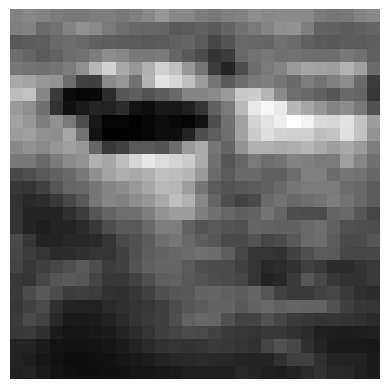

In [ ]:
img,label = train_data[1]
image_np = img.squeeze()
print(image_np.shape)
# Plot the image
plt.imshow(image_np,cmap="gray")
plt.axis('off')  # Hide the axes for better visualization
plt.show()

# Functions

## Check GPU

In [8]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'NVIDIA GeForce GTX 1650'

In [57]:
#function to clear tensorboard files

def clear_folder(folder_path):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return
    
    # Iterate through all items in the folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        try:
            # Remove directories
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
            # Remove files
            else:
                os.remove(item_path)
            print(f"Deleted: {item_path}")
        except Exception as e:
            print(f"Failed to delete {item_path}: {e}")
    
    print(f"All contents of the folder '{folder_path}' have been cleared.")
    #location of tensorboard folder
folder="runs/DisplayImage"


class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 2 (0-1)

        """
        super(NN, self).__init__()
        # # Our first linear layer take input_size, in this case 784 nodes to 50
        # # and our second linear layer takes 50 to the num_classes we have, in
        # # this case 10.
        # self.fc1 = nn.Linear(input_size, 50)
        # self.fc2 = nn.Linear(50, num_classes)

        self.flatten = nn.Flatten() #flattens the input tensors
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
            # nn.ReLU(),
            # nn.Linear(512, 2)
        )

    def forward(self, x):
        """
        x here is the mnist images and we run it through the network that we created above.
        Parameters:
            x: mnist images
        Returns:
            out: the output of the network
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(  #same convolution
            in_channels=in_channels,
            out_channels=8,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16, 
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    accuracies=[]
    batch_loss=0
    for batch, (input_data, class_cat) in enumerate(tqdm(dataloader)):
        input_data, class_cat = input_data.to(device), class_cat.to(device)

        ## Compute prediction error
        pred = model(input_data)
        class_cat=class_cat.squeeze().long()
        loss = loss_fn(pred, class_cat)

        ## Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        ## calculation running loss
        loss, current = loss.item(), (batch + 1) * len(input_data)


        ##caculating running accuracy
        _, predictions = pred.max(1)
        num_correct = (predictions == class_cat).sum()
        running_train_acc = float(num_correct) / float(input_data.shape[0])
        # print("model Output>>>>>")
        # print(pred)
        # print("predictions>>>")
        # print(predictions)
        # print("num_correct>>>>>")
        # print(num_correct)
        # print("accuracy>>>>")
        # print(running_train_acc)
        # print(data.shape[0])
        # print(input_data.shape[0])
        accuracies.append(running_train_acc)

        ##Plot stuff to tensorboard tensorboard
        global step
        writer.add_scalar("Batch/Training loss",loss,global_step=step)
        writer.add_scalar("Batch/Training Accuracy", running_train_acc, global_step=step)
        # global batch_loss
        # batch_loss.append(loss)
        batch_loss+=loss

        
        step += 1


        #print(f"loss: {loss:>7f} accuracy: {running_train_acc:>5f}  [{current:>5d}/{size:>5d}]")
    
    ## Calculate epoch accuracy
    epoch_accuracy=sum(accuracies)/len(accuracies)

    ## Getting the average epoch loss
    epoch_loss=batch_loss/size
    
    ## Send it to tensorboard
    writer.add_scalars("Epoch/Epoch loss",{'Train':epoch_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Train":epoch_accuracy},global_step=epoch)
    

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y=y.squeeze().long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    writer.add_scalars("Epoch/Epoch loss",{'Test':test_loss},global_step=epoch)
    writer.add_scalars("Epoch/Epoch Accuracy",{"Test":correct},global_step=epoch)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

class NN2(nn.Module):
    def __init__(self, input_size, num_classes):
        """
        Here we define the layers of the network. We create two fully connected layers

        Parameters:
            input_size: the size of the input, in this case 784 (28x28)
            num_classes: the number of classes we want to predict, in this case 10 (0-9)

        """
        super(NN2, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.flatten = nn.Flatten() #flattens the input tensors
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        x here is the mnist images and we run it through fc1, fc2 that we created above.
        we also add a ReLU activation function in between and for that (since it has no parameters)
        I recommend using nn.functional (F)

        Parameters:
            x: mnist images

        Returns:
            out: the output of the network
        """
        x=self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [51]:
#basinc testing for the model
model=CNN()
x=torch.randn(20,1,28,28)
print(model(x).shape)

model=NN2(input_size=28*28,num_classes=2)
x=torch.randn(20,1,28,28)
print(model(x).shape)

torch.Size([20, 2])
torch.Size([20, 2])


# Fully connected network


In [62]:
# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.001
#batch_size = 64 Note: this was determined when we loaded the data previously
num_epochs = 100

model = NN(input_size=input_size, num_classes=num_classes).to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    test(test_loader, model, loss_fn)

print("Done!")

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=2, bias=True)
  )
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733797824.DESKTOP-3FC1MTH.40840.118
All contents of the folder 'runs/DisplayImage' have been cleared.
Model sent to tensorboard
Epoch 1
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 143.94it/s]


Test Error: 
 Accuracy: 75.0%, Avg loss: 0.533205 

Epoch 2
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 158.32it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.517741 

Epoch 3
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.29it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.510035 



Epoch 4
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.01it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.502677 



Epoch 5
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.53it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.516041 



Epoch 6
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 178.47it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.493397 



Epoch 7
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 186.06it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.492445 

Epoch 8
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.22it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.488169 

Epoch 9
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 176.26it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.459503 

Epoch 10
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.98it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.457418 



Epoch 11
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 181.29it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.477674 



Epoch 12
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 183.48it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.521227 



Epoch 13
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.12it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.464102 

Epoch 14
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 176.48it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.563768 

Epoch 15
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 181.45it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.548192 

Epoch 16
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 168.69it/s]

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.453748 



Epoch 17
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 177.86it/s]

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.453164 



Epoch 18
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 175.99it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.453924 

Epoch 19
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 181.98it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.454376 



Epoch 20
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 171.10it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.490074 

Epoch 21
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 176.19it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.654796 

Epoch 22
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.45it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.451724 



Epoch 23
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.81it/s]

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.445933 



Epoch 24
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.06it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.455746 

Epoch 25
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 164.04it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.488155 



Epoch 26
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 178.92it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.493271 

Epoch 27
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.17it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.452018 

Epoch 28
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.08it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.442471 

Epoch 29
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.69it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.449388 

Epoch 30
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 180.23it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.442055 

Epoch 31
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.94it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.466743 

Epoch 32
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.42it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.496477 



Epoch 33
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.18it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.444652 



Epoch 34
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.61it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.444941 



Epoch 35
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 158.66it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.496539 

Epoch 36
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.71it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.446613 

Epoch 37
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 176.65it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.453177 



Epoch 38
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 176.52it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.466414 



Epoch 39
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 175.82it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.448125 



Epoch 40
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 153.88it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.462004 

Epoch 41
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.31it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.472979 

Epoch 42
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.05it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.456727 



Epoch 43
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.28it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.471394 



Epoch 44
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.17it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.466152 



Epoch 45
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.45it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.444174 

Epoch 46
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.00it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.456319 



Epoch 47
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.63it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.454939 



Epoch 48
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.57it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.474361 



Epoch 49
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.20it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.564099 



Epoch 50
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.28it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.450630 



Epoch 51
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.66it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.447181 



Epoch 52
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 158.12it/s]


Test Error: 
 Accuracy: 76.9%, Avg loss: 0.454387 

Epoch 53
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.18it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.629802 

Epoch 54
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.55it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.475508 



Epoch 55
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.09it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.452439 

Epoch 56
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 176.32it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.452572 



Epoch 57
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.07it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.448940 



Epoch 58
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.81it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.537681 

Epoch 59
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 179.52it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.468996 



Epoch 60
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 177.52it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.482763 



Epoch 61
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.43it/s]

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.508680 



Epoch 62
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 178.18it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.460080 



Epoch 63
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.23it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.456651 



Epoch 64
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 165.09it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.633224 

Epoch 65
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.08it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.558983 



Epoch 66
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.34it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.500102 

Epoch 67
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 176.37it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.461096 



Epoch 68
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 178.12it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.508741 



Epoch 69
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.37it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.506468 

Epoch 70
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.23it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.479818 

Epoch 71
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.53it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.466287 



Epoch 72
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.84it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.508114 

Epoch 73
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 177.09it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.555135 



Epoch 74
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 165.54it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.511280 



Epoch 75
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 175.00it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.536048 



Epoch 76
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.18it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.685073 



Epoch 77
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 176.10it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.485108 

Epoch 78
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.19it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.586426 

Epoch 79
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.27it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.493073 

Epoch 80
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.70it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.497487 

Epoch 81
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 184.56it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.507155 

Epoch 82
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.74it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.484254 

Epoch 83
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 156.67it/s]


Test Error: 
 Accuracy: 75.6%, Avg loss: 0.504801 

Epoch 84
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.96it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.520424 



Epoch 85
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.57it/s]

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.514957 



Epoch 86
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 171.92it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.798476 

Epoch 87
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 165.45it/s]

Test Error: 
 Accuracy: 78.8%, Avg loss: 0.591293 



Epoch 88
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.16it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.545771 

Epoch 89
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.89it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.497593 



Epoch 90
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 178.59it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.522705 

Epoch 91
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.77it/s]


Test Error: 
 Accuracy: 78.8%, Avg loss: 0.513900 

Epoch 92
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.17it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.560717 

Epoch 93
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 164.56it/s]

Test Error: 
 Accuracy: 76.3%, Avg loss: 0.547163 



Epoch 94
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.91it/s]

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.521273 



Epoch 95
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 175.19it/s]


Test Error: 
 Accuracy: 76.3%, Avg loss: 0.506977 

Epoch 96
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.25it/s]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.523496 

Epoch 97
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.30it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.527462 



Epoch 98
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 175.29it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.505175 



Epoch 99
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.54it/s]

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.545279 



Epoch 100
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 171.87it/s]

Test Error: 
 Accuracy: 62.8%, Avg loss: 0.859600 



Done!


# CNN

In [43]:
# Full implementation

# Hyperparameters
input_size = 28*28
num_classes = 2
learning_rate = 0.005
batch_size = 64
num_epochs = 100

model = CNN().to(device)
print(model)
## Setting up training and test function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

##clear tensorboard folder
clear_folder(folder)
writer = SummaryWriter(f"runs/DisplayImage")

# Visualize model in TensorBoard
example_img, labels = next(iter(train_loader))
#example_img=example_img[0]
writer.add_graph(model,example_img.to(device))
print("Model sent to tensorboard")

step=0
# epoch_loss=[]
for t in range(num_epochs):
    epoch=t
    # batch_loss=[]
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    
    # epoch_loss.append(sum(batch_loss)/len(batch_loss))
    # writer.add_scalar("Epoch Training loss",epoch_loss[t],global_step=t)
    test(test_loader, model, loss_fn)

print("Done!")

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=2, bias=True)
)
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch Accuracy_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch Accuracy_Train'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Test: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Test'
Failed to delete runs/DisplayImage\Epoch_Epoch loss_Train: [WinError 5] Access is denied: 'runs/DisplayImage\\Epoch_Epoch loss_Train'
Deleted: runs/DisplayImage\events.out.tfevents.1733796915.DESKTOP-3FC1MTH.40840.88
All contents of the folder 'runs/DisplayImage' have been cleared.


100%|██████████| 28/28 [00:00<00:00, 117.77it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.585896 

Epoch 2
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 149.57it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.567870 

Epoch 3
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 152.63it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.556257 

Epoch 4
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 150.11it/s]


Test Error: 
 Accuracy: 73.1%, Avg loss: 0.539150 

Epoch 5
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.08it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.528996 

Epoch 6
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.74it/s]


Test Error: 
 Accuracy: 73.7%, Avg loss: 0.511542 

Epoch 7
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 148.27it/s]


Test Error: 
 Accuracy: 74.4%, Avg loss: 0.507359 

Epoch 8
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 149.83it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.488284 

Epoch 9
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 161.43it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.482249 

Epoch 10
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 165.04it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.472979 

Epoch 11
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.99it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.472405 

Epoch 12
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.62it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.463227 

Epoch 13
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.42it/s]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.480956 

Epoch 14
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 161.55it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.459412 

Epoch 15
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 153.76it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.457825 

Epoch 16
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 165.68it/s]


Test Error: 
 Accuracy: 82.1%, Avg loss: 0.450856 

Epoch 17
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 153.79it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.451456 

Epoch 18
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.41it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.440664 

Epoch 19
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.76it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.436319 



Epoch 20
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 161.32it/s]

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.475895 

Epoch 21
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 166.97it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.459206 

Epoch 22
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 155.14it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.439942 

Epoch 23
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.37it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.434168 

Epoch 24
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 155.56it/s]

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.435787 



Epoch 25
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.65it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.427007 

Epoch 26
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.83it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.426217 

Epoch 27
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.56it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.431410 

Epoch 28
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.44it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.425934 

Epoch 29
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 153.60it/s]

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.418095 

Epoch 30
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 175.81it/s]


Test Error: 
 Accuracy: 82.1%, Avg loss: 0.434270 

Epoch 31
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.58it/s]

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.422089 



Epoch 32
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.75it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.417086 

Epoch 33
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.06it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.430163 

Epoch 34
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.64it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.434628 

Epoch 35
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.68it/s]

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.428215 



Epoch 36
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.44it/s]

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.414944 

Epoch 37
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 163.09it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.426889 

Epoch 38
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.36it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.426186 

Epoch 39
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.70it/s]

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.410957 



Epoch 40
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.52it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.421747 

Epoch 41
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.24it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.426762 

Epoch 42
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 152.36it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.430095 

Epoch 43
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.48it/s]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.471614 

Epoch 44
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.34it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.416072 

Epoch 45
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 164.03it/s]

Test Error: 
 Accuracy: 81.4%, Avg loss: 0.425881 

Epoch 46
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 165.73it/s]


Test Error: 
 Accuracy: 85.3%, Avg loss: 0.407903 

Epoch 47
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 164.53it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.416799 

Epoch 48
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.11it/s]


Test Error: 
 Accuracy: 80.8%, Avg loss: 0.463079 

Epoch 49
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.74it/s]


Test Error: 
 Accuracy: 85.3%, Avg loss: 0.411191 

Epoch 50
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 141.57it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.416038 

Epoch 51
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.72it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.424954 

Epoch 52
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.27it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.406986 

Epoch 53
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 159.51it/s]


Test Error: 
 Accuracy: 85.3%, Avg loss: 0.416571 

Epoch 54
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.67it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.420634 

Epoch 55
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 172.05it/s]

Test Error: 
 Accuracy: 80.1%, Avg loss: 0.461911 



Epoch 56
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 155.92it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.415979 

Epoch 57
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 155.24it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.427368 

Epoch 58
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 169.12it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.430049 

Epoch 59
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 156.63it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.416038 

Epoch 60
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.78it/s]

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.427250 



Epoch 61
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 156.33it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.422545 

Epoch 62
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.90it/s]

Test Error: 
 Accuracy: 82.7%, Avg loss: 0.423312 



Epoch 63
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.72it/s]

Test Error: 
 Accuracy: 80.8%, Avg loss: 0.436976 

Epoch 64
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 155.36it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.431868 

Epoch 65
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.05it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.426818 

Epoch 66
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.03it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.416705 

Epoch 67
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.26it/s]


Test Error: 
 Accuracy: 82.1%, Avg loss: 0.431678 

Epoch 68
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 174.00it/s]


Test Error: 
 Accuracy: 85.3%, Avg loss: 0.437054 

Epoch 69
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 161.81it/s]


Test Error: 
 Accuracy: 82.1%, Avg loss: 0.441928 

Epoch 70
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.19it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.425492 

Epoch 71
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 173.26it/s]

Test Error: 
 Accuracy: 84.6%, Avg loss: 0.433615 



Epoch 72
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 164.60it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.421926 

Epoch 73
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.82it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.436052 

Epoch 74
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 152.53it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.440137 

Epoch 75
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.56it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.436280 

Epoch 76
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.26it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.426890 

Epoch 77
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 167.64it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.435894 

Epoch 78
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.58it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.438792 

Epoch 79
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 146.93it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.445358 

Epoch 80
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 154.93it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.426591 

Epoch 81
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 158.09it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.429233 

Epoch 82
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 153.53it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.446325 

Epoch 83
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 155.94it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.432920 

Epoch 84
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 159.90it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.440539 

Epoch 85
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 168.27it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.439937 

Epoch 86
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.11it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.439868 

Epoch 87
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.88it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.424432 

Epoch 88
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 163.08it/s]

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.435260 



Epoch 89
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 157.34it/s]

Test Error: 
 Accuracy: 84.6%, Avg loss: 0.445463 

Epoch 90
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 165.13it/s]


Test Error: 
 Accuracy: 80.1%, Avg loss: 0.469208 

Epoch 91
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.77it/s]


Test Error: 
 Accuracy: 83.3%, Avg loss: 0.441085 

Epoch 92
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 166.38it/s]

Test Error: 
 Accuracy: 81.4%, Avg loss: 0.461852 

Epoch 93
-------------------------------



100%|██████████| 28/28 [00:00<00:00, 150.04it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.457909 

Epoch 94
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.29it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.448960 

Epoch 95
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.77it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.442398 

Epoch 96
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 162.45it/s]


Test Error: 
 Accuracy: 81.4%, Avg loss: 0.463231 

Epoch 97
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 170.36it/s]


Test Error: 
 Accuracy: 84.6%, Avg loss: 0.467238 

Epoch 98
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 158.34it/s]


Test Error: 
 Accuracy: 84.0%, Avg loss: 0.440031 

Epoch 99
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 160.91it/s]


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.454972 

Epoch 100
-------------------------------


100%|██████████| 28/28 [00:00<00:00, 156.44it/s]

Test Error: 
 Accuracy: 84.6%, Avg loss: 0.459283 

Done!
